# Condition number of Wout

Instability is not clear from this... Condition number is lower for Nsub=1 than Nsub=16... and it's all O(1-10), so
not clear from this.

In [78]:
import os
import sys

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns

In [6]:
sys.path.append("..")
from rcgfd import NVARDataset

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [20]:
class WOutDataset(NVARDataset):
    chunks = None
    def __call__(self):
 
        dslist=[]
        for n_sub in self.n_sub:
            dslist2 = []
            for n_lag in self.n_lag:
                dslist2.append( self.open_single_dataset(n_lag, n_sub) )
            dslist.append(xr.concat(dslist2, dim='n_lag'))
        xds = xr.concat(dslist, dim='n_sub')
        return xds
    
    def get_results_path(self, n_lag, n_sub):
        dt0 = 300
        delta_t = n_sub * dt0
        main_dir = f"micro-calibration-{delta_t:04d}dt-lag{n_lag:02d}-nb{self.n_overlap:02d}/"
        fname = f"/contrib/Tim.Smith/qgrc-teachers/sqg/resolution/aws-resolution-results/nvar-temporal-sampling-064n/{main_dir}/rcmodel.zarr"
        return main_dir, fname


In [21]:
wod = WOutDataset(
    n_sub=(1,4,16),
    n_lag=(0,1,2,3),
)

In [22]:
ds = wod()

In [70]:
Wout = ds.Wout

In [38]:
from numpy import linalg

In [95]:
%%time
conds = xr.zeros_like(ds.n_sub*ds.n_lag*ds.ig, dtype=np.float64)
for n_sub in ds.n_sub.values:
    for n_lag in ds.n_lag.values:
        findme = {"n_sub":n_sub, "n_lag":n_lag}
        try:
            conds.loc[findme] = linalg.cond(ds["Wout"].sel(findme).dropna("ir").values)
        except linalg.LinAlgError:
            conds.loc[findme] = np.nan

CPU times: user 1min 9s, sys: 5.18 s, total: 1min 14s
Wall time: 22.8 s


<AxesSubplot: xlabel='n_lag', ylabel='Condition Number'>

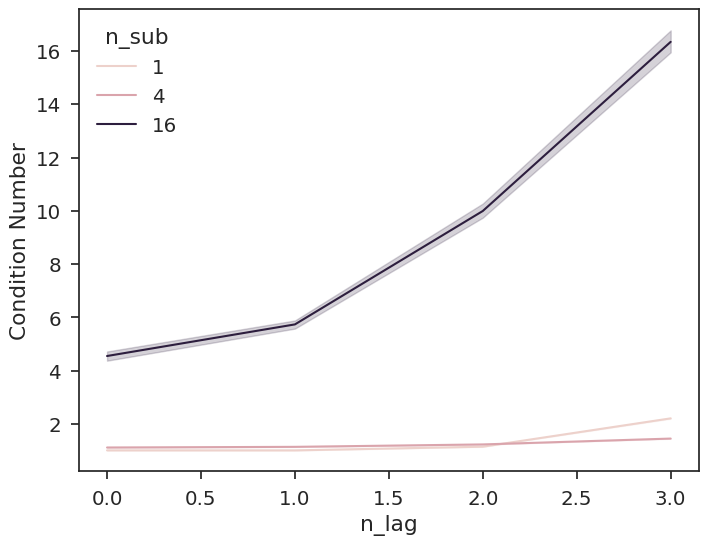

In [98]:
fig, ax = plt.subplots()

sns.lineplot(
    data=conds.to_dataset(name="Condition Number").to_dataframe().reset_index(),
    x="n_lag",
    hue="n_sub",
    y="Condition Number",
    ax=ax
)

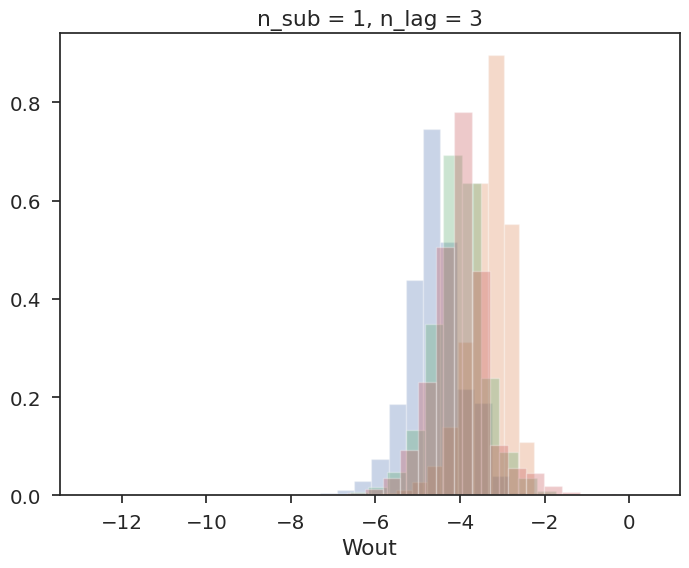

In [69]:
for n_lag in xds.n_lag.values:
    np.log10(np.abs(ds.Wout.sel(n_sub=1,n_lag=n_lag).dropna('ir'))).plot.hist(bins=30,alpha=.3, density=True)